In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import widgets, Layout
from IPython.display import display
import seaborn as sns
from nipype.interfaces.ants import N4BiasFieldCorrection
from nipype.interfaces.afni import SkullStrip, Resample, Warp
from nipype.interfaces.fsl import FLIRT

/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [33]:
sns.set_context('poster')

In [3]:
img_file = '/home/julia/projects/lc/nifti/20181220_102400_JH_20181220_lcrsfmri_test03_1_1_nifti/JH20181220lcrsfmritest03/JH20181220lcrsfmritest03_19/JH20181220lcrsfmritest03_19.nii.gz'
img = nb.load(img_file)
img_data=img.get_data()

In [4]:
avg = np.average(img_data, axis=3)
nb.Nifti1Image(avg, img.affine, img.header).to_filename('/home/julia/projects/gradients/fisp_1/19_avg.nii.gz')

In [35]:
data=masked_data[:,:,:,100]
z = data.shape[2]//2
def plot_z(z=z):
    fig, axes = plt.subplots(1,1)
    ax = axes
    ax.axis('off')
    ax.matshow((data[:, :, z]).T, cmap="Greys_r", interpolation='none')#, vmin=1000, vmax=5000)
    #ax.matshow((mask_low[:, :, z]).T, cmap="Reds", interpolation='none', alpha=0.5)
    fig.set_size_inches(8, 8)
    return fig

interactive_plot_z = widgets.interactive(plot_z,z=widgets.IntSlider(min=0, max=data.shape[2]-1,value=z))
display(interactive_plot_z)

interactive(children=(IntSlider(value=5, description='z', max=9), Output()), _dom_classes=('widget-interact',))

In [8]:
n4 = N4BiasFieldCorrection(input_image='/home/julia/projects/gradients/fisp_1/19_avg.nii.gz', dimension=3,
                           n_iterations=[150,100,50,30], convergence_threshold=1e-11,
                           bspline_fitting_distance = 10, bspline_order = 4,
                           shrink_factor = 2,
                           output_image= '/home/julia/projects/gradients/fisp_1/19_n4.nii.gz')
n4.run()

In [9]:
iso = FLIRT(in_file='/home/julia/projects/gradients/fisp_1/19_n4.nii.gz',
              reference='/home/julia/projects/gradients/fisp_1/19_n4.nii.gz',
               out_file='/home/julia/projects/gradients/fisp_1/19_iso.nii.gz',
              apply_isoxfm=0.2)
iso.run()

In [9]:
skull = SkullStrip(in_file='/home/julia/projects/gradients/fisp_1/19_iso.nii.gz', 
                   out_file='/home/julia/projects/gradients/fisp_1/19_iso_masked.nii.gz', outputtype='NIFTI_GZ',
                   args='-rat -orig_vol')

skull.run()

190102-09:59:48,415 nipype.interface INFO:
	 stderr 2019-01-02T09:59:48.415819:*+ WARNING:   If you are performing spatial transformations on an oblique dset, 
190102-09:59:48,417 nipype.interface INFO:
	 stderr 2019-01-02T09:59:48.415819:  such as /home/julia/projects/gradients/fisp_1/19_iso.nii.gz,
190102-09:59:48,420 nipype.interface INFO:
	 stderr 2019-01-02T09:59:48.415819:  or viewing/combining it with volumes of differing obliquity,
190102-09:59:48,423 nipype.interface INFO:
	 stderr 2019-01-02T09:59:48.415819:  you should consider running: 
190102-09:59:48,426 nipype.interface INFO:
	 stderr 2019-01-02T09:59:48.415819:     3dWarp -deoblique 
190102-09:59:48,427 nipype.interface INFO:
	 stderr 2019-01-02T09:59:48.415819:  on this and  other oblique datasets in the same session.
190102-09:59:48,428 nipype.interface INFO:
	 stderr 2019-01-02T09:59:48.415819: See 3dWarp -help for details.
190102-09:59:48,430 nipype.interface INFO:
	 stderr 2019-01-02T09:59:48.415819:++ Oblique data

In [10]:
masked = nb.load('/home/julia/projects/gradients/fisp_1/19_iso_masked.nii.gz')
binmask = np.where(masked.get_data()>0, 1, 0)
nb.Nifti1Image(binmask, masked.affine, masked.header).to_filename('/home/julia/projects/gradients/fisp_1/19_iso_mask.nii.gz')

In [11]:
resamp = Resample(in_file='/home/julia/projects/gradients/fisp_1/19_iso_mask.nii.gz',
                 resample_mode='NN', master='/home/julia/projects/gradients/fisp_1/19_n4.nii.gz',
                 out_file='/home/julia/projects/gradients/fisp_1/19_mask.nii.gz')
resamp.run()

190102-10:03:16,674 nipype.interface INFO:
	 stderr 2019-01-02T10:03:16.674309:*+ WARNING:   If you are performing spatial transformations on an oblique dset, 
190102-10:03:16,675 nipype.interface INFO:
	 stderr 2019-01-02T10:03:16.674309:  such as /home/julia/projects/gradients/fisp_1/19_n4.nii.gz,
190102-10:03:16,676 nipype.interface INFO:
	 stderr 2019-01-02T10:03:16.674309:  or viewing/combining it with volumes of differing obliquity,
190102-10:03:16,677 nipype.interface INFO:
	 stderr 2019-01-02T10:03:16.674309:  you should consider running: 
190102-10:03:16,678 nipype.interface INFO:
	 stderr 2019-01-02T10:03:16.674309:     3dWarp -deoblique 
190102-10:03:16,679 nipype.interface INFO:
	 stderr 2019-01-02T10:03:16.674309:  on this and  other oblique datasets in the same session.
190102-10:03:16,681 nipype.interface INFO:
	 stderr 2019-01-02T10:03:16.674309: See 3dWarp -help for details.
190102-10:03:16,681 nipype.interface INFO:
	 stderr 2019-01-02T10:03:16.674309:++ Oblique datas

In [12]:
mask_low = nb.load('/home/julia/projects/gradients/fisp_1/19_mask.nii.gz').get_data()

In [18]:
masked_avg = mask_low*avg

In [20]:
masked_data = img_data.copy()

In [23]:
for t in range(img_data.shape[3]):
    masked_data[:,:,:,t]=masked_data[:,:,:,t]*mask_low

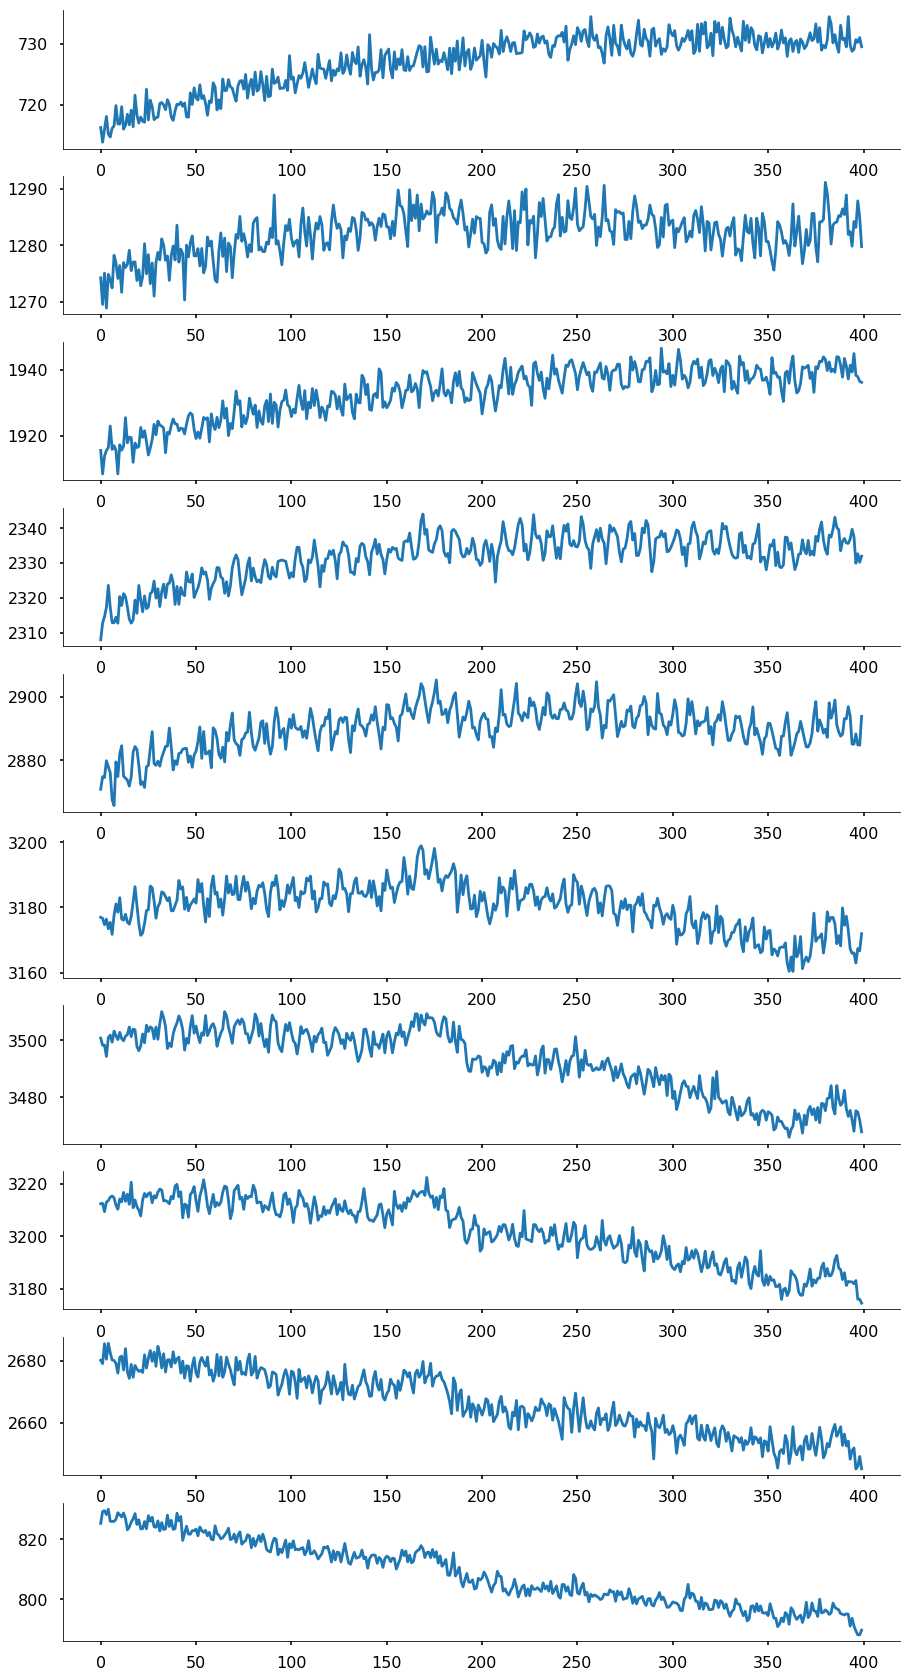

In [49]:
s=5
fig = plt.figure(figsize=(15,30))
for s in range(10):
    fig.add_subplot(10,1,s+1)
    plt.plot(np.average(masked_data[:,:,s,100:], axis=(0,1)))
sns.despine()

In [24]:
masked_data.shape

(60, 90, 10, 500)

In [52]:
print(img.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  4  60  90  10 500   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.         0.20001338 0.2        0.6500435  1.         1.
 1.         1.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : aligned
quatern_b       : 0.035119306
quatern_c       : -1.110223e-16
quatern_d       : -0.99938315
qoffset_x       : 5.8974
qoffset_y     

In [57]:
method=np.load('/home/julia/projects/lc/nifti/20181220_102400_JH_20181220_lcrsfmri_test03_1_1_nifti/JH20181220lcrsfmritest03/JH20181220lcrsfmritest03_19/JH20181220lcrsfmritest03_19_method.npy')[()]

In [62]:
method['RepetitionTime']

2.65

In [61]:
method

{'AcquisitionTime': 0.684,
 'Alpha2_Prep_time': 0.5,
 'AntiAlias': array([1., 1.]),
 'Const_separation': 0.0,
 'DATATYPE': 'Parameter Values',
 'DefMatrix': array([128., 128.,  64.]),
 'DeriveGains': 'Yes',
 'DigAutSet': 'Yes',
 'DigDur': 0.684,
 'DigDw': 0.0076,
 'DigEndDelMin': 0.0,
 'DigEndDelOpt': 0.0324032403240323,
 'DigFilter': 'Digital_Medium',
 'DigGroupDel': 0.2736,
 'DigNp': 90.0,
 'DigQuad': 'Yes',
 'DigRes': 20.0,
 'DigShift': 36.0,
 'DigShiftDbl': 36.0,
 'DigSw': 131578.947368421,
 'DummyScans': 0.0,
 'DummyScansDur': 0.0,
 'Durations1_text': '0',
 'Durations2_text': '',
 'END': '',
 'EchoPosition': 50.0,
 'EchoTime': 1.325,
 'EffPhase0Offset': array([0.383054, 0.383054, 0.383054, 0.383054, 0.383054, 0.383054,
        0.383054, 0.383054, 0.383054, 0.383054]),
 'EffPhase1Offset': array([-0.10281893, -0.10281893, -0.10281893, -0.10281893, -0.10281893,
        -0.10281893, -0.10281893, -0.10281893, -0.10281893, -0.10281893]),
 'EffPhase2Offset': array([0., 0., 0., 0., 0., 0.

In [64]:
919594.874891625 / 60000 

15.326581248193751

In [66]:
919594.874891625 / 500000

1.8391897497832501